In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import sklearn.metrics
import seaborn as sns
import itertools
from autogluon.tabular import TabularPredictor

In [2]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [9]:
train_log = train
train_log['Calories'] = np.log1p(train['Calories'])
train_log['Sex'] = train_log['Sex'].astype('category')

train_log.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,5.017280
1,female,64,163,60,8,85,39.7,3.555348
2,female,51,161,64,7,84,39.8,3.401197
3,male,20,192,90,25,105,40.7,4.948760
4,female,38,166,61,25,102,40.6,4.990433


In [10]:
# Split data into training and testing sets
train_data, test_data = train_test_split(train_log, test_size=0.2, random_state=724)

In [3]:
# Ensemble best two models!

# load the models
predictor6 = TabularPredictor.load(r"c:\Users\eblac\Documents\GitHub\S25_Predict_Calories\AutogluonModels\ag-20250608_151409")
predictor11 = TabularPredictor.load(r"c:\Users\eblac\Documents\GitHub\S25_Predict_Calories\AutogluonModels\ag-20250609_212233")

In [5]:
predictor11.leaderboard().head()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.059075,root_mean_squared_error,7214.105045,30590.482822,0.015257,10.400178,3,True,64
1,WeightedEnsemble_L2,-0.059187,root_mean_squared_error,1472.380559,3711.962613,0.013062,8.115282,2,True,48
2,ExtraTreesMSE_BAG_L2,-0.059404,root_mean_squared_error,6798.435167,25700.223948,30.450780,526.690415,2,True,53
3,CatBoost_r9_BAG_L2,-0.059462,root_mean_squared_error,6770.174446,25586.323037,2.190059,412.789504,2,True,62
4,LightGBMLarge_BAG_L2,-0.059492,root_mean_squared_error,6777.622296,25247.191057,9.637909,73.657524,2,True,57


In [6]:
predictor11.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val              eval_metric  pred_time_val      fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -0.059075  root_mean_squared_error    7214.105045  30590.482822                0.015257          10.400178            3       True         64
1           WeightedEnsemble_L2  -0.059187  root_mean_squared_error    1472.380559   3711.962613                0.013062           8.115282            2       True         48
2          ExtraTreesMSE_BAG_L2  -0.059404  root_mean_squared_error    6798.435167  25700.223948               30.450780         526.690415            2       True         53
3            CatBoost_r9_BAG_L2  -0.059462  root_mean_squared_error    6770.174446  25586.323037                2.190059         412.789504            2       True         62
4          LightGBMLarge_BAG_L2  -0.059492  root_mean_squared_e

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'CatBoost_r9_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r96_BAG_L1': 'StackerEnsembleModel

In [11]:
predictor11.feature_importance(train_data)

,importance,stddev,p_value,n,p99_high,p99_low
Duration,0.806995,0.010962,4.084816e-09,5,0.829567,0.784424
Heart_Rate,0.461166,0.013544,8.917708e-08,5,0.489054,0.433279
Age,0.113267,0.002252,1.872867e-08,5,0.117903,0.108631
Sex,0.059944,0.002045,1.622515e-07,5,0.064154,0.055733
Body_Temp,0.035696,0.001747,6.869874e-07,5,0.039294,0.032098
Weight,0.016841,0.000698,3.534277e-07,5,0.018278,0.015404
Height,0.004005,0.000377,9.331977e-06,5,0.004781,0.003228


In [4]:
info11 = predictor11.info()

In [ ]:
# make predictions on the test set
ag6_pred = predictor6.predict(test_data)
ag11_pred = predictor11.predict(test_data)

In [9]:
# Create the ensemble model

# The weights of the model 0, 0.01, 0.02, ..., 0.99, 1
testweights = np.arange(start=0, stop=1.01, step=0.01)

model_err = {}

for w in testweights:
    
    # y_pred = model.predict(X_test)
    # y_pred[y_pred <= 0] = 1
    # score = rmse(y_test, y_pred)
    # scores.append(score)

    model_err[f"weight_{w}"] = rmse(test_data['Calories'], w*ag6_pred + (1-w)*ag11_pred)


# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

The key with the minimum value is 'weight_0.0' with a value of 0.05890854581655313.


In [15]:
# make predictions on the training set
ag6_pred_train = predictor6.predict(train_data)
ag11_pred_train = predictor11.predict(train_data)

In [18]:
ag6_pred_train.to_csv("ag6train_pred.csv", index=False)
ag11_pred_train.to_csv("ag11train_pred.csv", index=False)

ag6_pred.to_csv("ag6test_pred.csv", index=False)
ag11_pred.to_csv("ag11test_pred.csv", index=False)

In [17]:
# Stack predictions as features
X_stack = np.vstack((ag6_pred_train, ag11_pred_train)).T

# Split for training meta-model
# X_train, X_val, y_train, y_val = train_test_split(X_stack, test_data['Calories'], test_size=0.2)

# Fit meta-model
meta_model = LinearRegression()
meta_model.fit(X_stack, train_data['Calories'])

# Final predictions
ensemble_preds_train = meta_model.predict(train_data[['Calories']])
ensemble_preds_test = meta_model.predict(test_data[['Calories']])

print("Error on training data:", rmse(train_data['Calories'], ensemble_preds_train))
print("Error on test data:", rmse(test_data['Calories'], ensemble_preds_test))

c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: X has 1 features, but LinearRegression is expecting 2 features as input.

In [ ]:
# kaggle score 0.0???? private, 0.0???? public (autogluon_prediction_12.csv) (tied for ??th place out of 4318 teams)

# Train the model
predictor = TabularPredictor(label='Calories',
                             problem_type='regression',
                             eval_metric='root_mean_squared_error').fit(train_data,
                                                                        presets="best_quality",
                                                                        time_limit=43200, # 12 hours
                                                                        num_bag_folds=5,  # 5 fold CV
                                                                        verbosity=1
                                                                        )

# Make predictions
train_pred = predictor.predict(train_data)
test_pred = predictor.predict(test_data)
predictions = predictor.predict(test)

# Evaluate
print()
print("Train prediction:", rmse(train_pred, train_data['Calories']))
print("Test prediction:", rmse(test_pred, test_data['Calories']))



# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(test_data['Calories']))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(predictions)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("autogluon_prediction_12.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

No path specified. Models will be saved in: "AutogluonModels\ag-20250611_230221"
2025-06-11 19:02:25,722	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(_dystack pid=25528) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=25528)   warnings.warn(
(_dystack pid=25528) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=25528)   warnings.warn(
(_dystack pid=25528) c:\Users\eblac\anaconda3\envs\erdo

No path specified. Models will be saved in: "AutogluonModels\ag-20250609_212233"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       5.58 GB / 11.33 GB (49.2%)
Disk Space Avail:   75.36 GB / 237.53 GB (31.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdou

(_ray_fit pid=8788) [1000]	valid_set's rmse: 0.0625831
(_ray_fit pid=11928) [1000]	valid_set's rmse: 0.0607507 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=8788) [2000]	valid_set's rmse: 0.0610258 [repeated 2x across cluster]
(_ray_fit pid=11928) [2000]	valid_set's rmse: 0.0595853 [repeated 3x across cluster]
(_ray_fit pid=8788) [3000]	valid_set's rmse: 0.0606761 [repeated 2x across cluster]
(_ray_fit pid=11928) [3000]	valid_set's rmse: 0.0593409 [repeated 3x across cluster]
(_ray_fit pid=8788) [4000]	valid_set's rmse: 0.0605654 [repeated 2x across cluster]
(_ray_fit pid=13868) [4000]	valid_set's rmse: 0.0608674 [repeated 2x across cluster]
(_ray_fit pid=11928) [4000]	valid_set's rmse: 0.059248
(_ray_fit pid=16632) [4000]	valid_set's rmse: 0.0624467
(_ray_fit pid=8788) [5000]	va

(_dystack pid=4760) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	323.26s	 = Training   runtime
(_dystack pid=4760) 	693.51s	 = Validation runtime
(_dystack pid=4760) Fitting model: LightGBM_BAG_L1 ... Training model for up to 8499.35s of the 12998.55s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=3.50%)


(_ray_fit pid=14252) [1000]	valid_set's rmse: 0.0606108
(_ray_fit pid=5388) [2000]	valid_set's rmse: 0.0594929 [repeated 5x across cluster]


(_dystack pid=4760) 	-0.0606	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	47.38s	 = Training   runtime
(_dystack pid=4760) 	38.5s	 = Validation runtime
(_dystack pid=4760) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 8438.28s of the 12937.47s of remaining time.
(_dystack pid=4760) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=4760)   warnings.warn(
(_dystack pid=4760) 	-0.0635	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	101.27s	 = Training   runtime
(_dystack pid=4760) 	16.92s	 = Validation runtime
(_dystack pid=4760) Fitting model: CatBoost_BAG_L1 ... Training model for up to 8319.24s of the 12818.43s of remaining time.
(_dystack pid=4760

(_ray_fit pid=15628) [1000]	valid_set's rmse: 0.0603741


(_dystack pid=4760) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	36.42s	 = Training   runtime
(_dystack pid=4760) 	28.25s	 = Validation runtime
(_dystack pid=4760) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 7039.38s of the 11538.57s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=10.11%)
(_ray_fit pid=16460) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\autogluon\common\utils\try_import.py:69: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(_ray_fit pid=16460)   from pkg_resources import parse_version  # pylint: disable=import-outside-toplevel
(_dystack pid=4760) 	-0.06	 = Validation score   (-root_mean_s

(_ray_fit pid=9032) [1000]	valid_set's rmse: 0.0596325
(_ray_fit pid=9032) [2000]	valid_set's rmse: 0.0592112 [repeated 5x across cluster]
(_ray_fit pid=9032) [3000]	valid_set's rmse: 0.059135 [repeated 5x across cluster]
(_ray_fit pid=5060) [4000]	valid_set's rmse: 0.0606035 [repeated 5x across cluster]
(_ray_fit pid=7288) [5000]	valid_set's rmse: 0.0591161 [repeated 5x across cluster]


(_dystack pid=4760) 	-0.0603	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	143.26s	 = Training   runtime
(_dystack pid=4760) 	454.81s	 = Validation runtime
(_dystack pid=4760) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 5124.06s of the 9623.25s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=5.71%)
(_ray_fit pid=17064) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\autogluon\common\utils\try_import.py:131: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(_ray_fit pid=17064)   from pkg_resources import parse_version  # pylint: disable=import-outside-toplevel
(_ray_fit pid=17064) No improvement since epoch 4: ear

(_ray_fit pid=10936) [1000]	valid_set's rmse: 0.0833397 [repeated 2x across cluster]
(_ray_fit pid=8548) [2000]	valid_set's rmse: 0.0765656 [repeated 5x across cluster]
(_ray_fit pid=10936) [3000]	valid_set's rmse: 0.0692236 [repeated 5x across cluster]
(_ray_fit pid=10936) [4000]	valid_set's rmse: 0.0662483 [repeated 5x across cluster]
(_ray_fit pid=10936) [5000]	valid_set's rmse: 0.0644492 [repeated 5x across cluster]
(_ray_fit pid=10936) [6000]	valid_set's rmse: 0.063354 [repeated 5x across cluster]
(_ray_fit pid=10936) [7000]	valid_set's rmse: 0.0627078 [repeated 5x across cluster]
(_ray_fit pid=10936) [8000]	valid_set's rmse: 0.0621875 [repeated 5x across cluster]
(_ray_fit pid=10936) [9000]	valid_set's rmse: 0.061852 [repeated 5x across cluster]
(_ray_fit pid=10936) [10000]	valid_set's rmse: 0.0616338 [repeated 5x across cluster]


(_dystack pid=4760) 	-0.0611	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	285.89s	 = Training   runtime
(_dystack pid=4760) 	1053.3s	 = Validation runtime
(_dystack pid=4760) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 1734.83s of the 6234.02s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=3.37%)
(_dystack pid=4760) 	-0.0631	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	968.13s	 = Training   runtime
(_dystack pid=4760) 	4.36s	 = Validation runtime
(_dystack pid=4760) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 760.63s of the 5259.82s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=5.02%)
(_ray_fit pid=13788) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\sit

(_ray_fit pid=14204) [1000]	valid_set's rmse: 0.0606739 [repeated 5x across cluster]
(_ray_fit pid=15168) [2000]	valid_set's rmse: 0.0586596 [repeated 5x across cluster]
(_ray_fit pid=3496) [3000]	valid_set's rmse: 0.059529 [repeated 4x across cluster]
(_ray_fit pid=12988) [4000]	valid_set's rmse: 0.0608958 [repeated 2x across cluster]
(_ray_fit pid=12988) [5000]	valid_set's rmse: 0.0608831 [repeated 2x across cluster]
(_ray_fit pid=12988) [6000]	valid_set's rmse: 0.0609023 [repeated 2x across cluster]


(_dystack pid=4760) 	-0.06	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	269.42s	 = Training   runtime
(_dystack pid=4760) 	301.51s	 = Validation runtime
(_dystack pid=4760) Fitting model: LightGBM_BAG_L2 ... Training model for up to 4142.80s of the 4142.58s of remaining time.
(_dystack pid=4760) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=2, gpus=0, memory=8.11%)
(_dystack pid=4760) 	-0.0597	 = Validation score   (-root_mean_squared_error)
(_dystack pid=4760) 	20.16s	 = Training   runtime
(_dystack pid=4760) 	2.93s	 = Validation runtime
(_dystack pid=4760) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 4115.34s of the 4115.13s of remaining time.
(_dystack pid=4760) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.valid


Train prediction: 0.05326184149654986
Test prediction: 0.05890856866854239


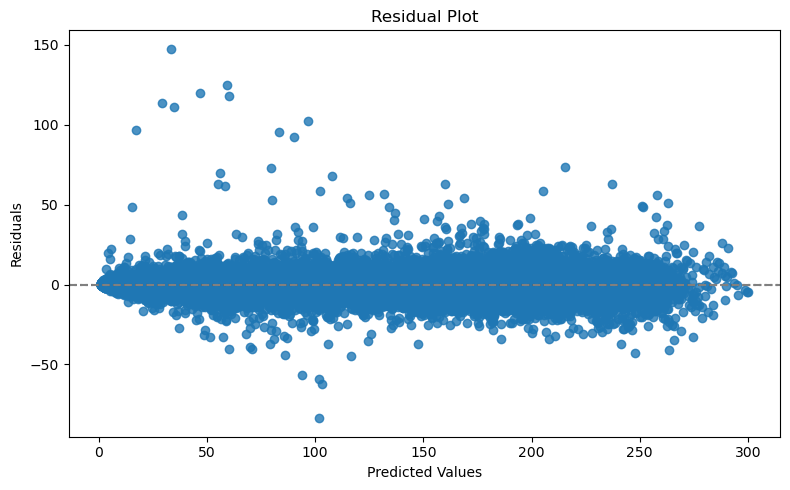

       id    Calories
0  750000   27.222017
1  750001  107.947952
2  750002   87.182053
3  750003  125.709190
4  750004   75.934334

count    250000.000000
mean         88.172859
std          62.275372
min           1.017824
25%          34.050141
50%          76.401817
75%         135.375736
max         299.757019
Name: Calories, dtype: float64


In [ ]:
# kaggle score 0.05849 private, 0.05701 public (autogluon_prediction_11.csv) (tied for 14th place out of 4318 teams)

# Train the model
predictor = TabularPredictor(label='Calories',
                             problem_type='regression',
                             eval_metric='root_mean_squared_error').fit(train_data,
                                                                        presets="best_quality",
                                                                        time_limit=54000, # 15 hours
                                                                        num_bag_folds=5,  # 5 fold CV
                                                                        )

# Make predictions
train_pred = predictor.predict(train_data)
test_pred = predictor.predict(test_data)
predictions = predictor.predict(test)

# Evaluate
print()
print("Train prediction:", rmse(train_pred, train_data['Calories']))
print("Test prediction:", rmse(test_pred, test_data['Calories']))



# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(test_data['Calories']))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(predictions)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("autogluon_prediction_11.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

In [8]:
predictor.leaderboard().head()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.059075,root_mean_squared_error,7214.105045,30590.482822,0.015257,10.400178,3,True,64
1,WeightedEnsemble_L2,-0.059187,root_mean_squared_error,1472.380559,3711.962613,0.013062,8.115282,2,True,48
2,ExtraTreesMSE_BAG_L2,-0.059404,root_mean_squared_error,6798.435167,25700.223948,30.450780,526.690415,2,True,53
3,CatBoost_r9_BAG_L2,-0.059462,root_mean_squared_error,6770.174446,25586.323037,2.190059,412.789504,2,True,62
4,LightGBMLarge_BAG_L2,-0.059492,root_mean_squared_error,6777.622296,25247.191057,9.637909,73.657524,2,True,57


In [6]:
info = predictor.info()

In [9]:
info['model_info']['WeightedEnsemble_L3']

{'name': 'WeightedEnsemble_L3',
 'model_type': 'WeightedEnsembleModel',
 'problem_type': 'regression',
 'eval_metric': 'root_mean_squared_error',
 'stopping_metric': 'root_mean_squared_error',
 'fit_time': 10.40017819404602,
 'num_classes': None,
 'quantile_levels': None,
 'predict_time': 0.01525735855102539,
 'val_score': np.float64(-0.059075210416038915),
 'hyperparameters': {'use_orig_features': False,
  'valid_stacker': True,
  'max_base_models': 0,
  'max_base_models_per_type': 'auto',
  'save_bag_folds': True,
  'stratify': 'auto',
  'bin': 'auto',
  'n_bins': None},
 'hyperparameters_user': {'save_bag_folds': True},
 'hyperparameters_fit': {},
 'hyperparameters_nondefault': ['save_bag_folds'],
 'ag_args_fit': {'max_memory_usage_ratio': 1.0,
  'max_time_limit_ratio': 1.0,
  'max_time_limit': None,
  'min_time_limit': 0,
  'valid_raw_types': None,
  'valid_special_types': None,
  'ignored_type_group_special': None,
  'ignored_type_group_raw': None,
  'get_features_kwargs': None,
 

In [10]:
info['model_info']['WeightedEnsemble_L3']['features']

['ExtraTreesMSE_BAG_L2',
 'CatBoost_r167_BAG_L1',
 'CatBoost_r69_BAG_L1',
 'LightGBMXT_BAG_L1',
 'LightGBMLarge_BAG_L2',
 'LightGBMXT_BAG_L2',
 'NeuralNetFastAI_r156_BAG_L1',
 'CatBoost_r9_BAG_L2',
 'LightGBMLarge_BAG_L1',
 'XGBoost_r33_BAG_L1',
 'XGBoost_r194_BAG_L1',
 'RandomForestMSE_BAG_L2',
 'CatBoost_r177_BAG_L2',
 'RandomForest_r39_BAG_L1']

No path specified. Models will be saved in: "AutogluonModels\ag-20250608_151409"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       22.55 GB / 31.61 GB (71.3%)
Disk Space Avail:   206.84 GB / 455.74 GB (45.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then hold

(_ray_fit pid=18124) [1000]	valid_set's rmse: 0.0625831
(_ray_fit pid=18124) [2000]	valid_set's rmse: 0.0610258 [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=19280) [3000]	valid_set's rmse: 0.0593409 [repeated 5x across cluster]
(_ray_fit pid=18124) [4000]	valid_set's rmse: 0.0605654 [repeated 5x across cluster]
(_ray_fit pid=18124) [5000]	valid_set's rmse: 0.0604907 [repeated 5x across cluster]
(_ray_fit pid=22396) [6000]	valid_set's rmse: 0.0593362 [repeated 5x across cluster]
(_ray_fit pid=22396) [7000]	valid_set's rmse: 0.0593263 [repeated 4x across cluster]
(_ray_fit pid=22396) [8000]	valid_set's rmse: 0.0593195 [repeated 3x across cluster]
(_ray_fit pid=22396) [9000]	valid_set's rmse: 0.0593148
(_ray_fit pid=22396) [10000]	valid_set's rmse: 0.0593298


(_dystack pid=23508) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=23508) 	201.28s	 = Training   runtime
(_dystack pid=23508) 	254.84s	 = Validation runtime
(_dystack pid=23508) Fitting model: LightGBM_BAG_L1 ... Training model for up to 1535.83s of the 2434.38s of remaining time.
(_dystack pid=23508) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=0.88%)


(_ray_fit pid=21964) [1000]	valid_set's rmse: 0.0596077
(_ray_fit pid=24344) [1000]	valid_set's rmse: 0.062869
(_ray_fit pid=21964) [2000]	valid_set's rmse: 0.0594929 [repeated 4x across cluster]


(_dystack pid=23508) 	-0.0606	 = Validation score   (-root_mean_squared_error)
(_dystack pid=23508) 	31.53s	 = Training   runtime
(_dystack pid=23508) 	17.85s	 = Validation runtime
(_dystack pid=23508) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 1497.86s of the 2396.40s of remaining time.
(_dystack pid=23508) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_dystack pid=23508)   warnings.warn(
(_dystack pid=23508) 	-0.0635	 = Validation score   (-root_mean_squared_error)
(_dystack pid=23508) 	59.64s	 = Training   runtime
(_dystack pid=23508) 	14.37s	 = Validation runtime
(_dystack pid=23508) Fitting model: CatBoost_BAG_L1 ... Training model for up to 1423.28s of the 2321.82s of remaining time.
(_dystack 

(_ray_fit pid=7980) [1000]	valid_set's rmse: 0.0603741


(_dystack pid=23508) 	-0.0604	 = Validation score   (-root_mean_squared_error)
(_dystack pid=23508) 	21.23s	 = Training   runtime
(_dystack pid=23508) 	12.96s	 = Validation runtime
(_dystack pid=23508) Fitting model: CatBoost_r177_BAG_L1 ... Training model for up to 775.30s of the 1673.85s of remaining time.
(_dystack pid=23508) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=2.64%)
(_dystack pid=23508) 	Warning: Exception caused CatBoost_r177_BAG_L1 to fail during training (ImportError)... Skipping this model.
(_dystack pid=23508) 		ray::_ray_fit() (pid=3484, ip=127.0.0.1)
(_dystack pid=23508)   File "c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\catboost\__init__.py", line 1, in <module>
(_dystack pid=23508)     from .core import (
(_dystack pid=23508)   File "c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packages\catboost\core.py", line 45, in <module>
(_dystack pid=23508)   

(_ray_fit pid=15704) [1000]	valid_set's rmse: 0.0596325
(_ray_fit pid=18504) [2000]	valid_set's rmse: 0.0606324 [repeated 5x across cluster]
(_ray_fit pid=18504) [3000]	valid_set's rmse: 0.0605689 [repeated 5x across cluster]
(_ray_fit pid=18504) [4000]	valid_set's rmse: 0.0606035 [repeated 5x across cluster]
(_ray_fit pid=20996) [5000]	valid_set's rmse: 0.0591161 [repeated 5x across cluster]


(_dystack pid=23508) 	-0.0603	 = Validation score   (-root_mean_squared_error)
(_dystack pid=23508) 	91.15s	 = Training   runtime
(_dystack pid=23508) 	212.06s	 = Validation runtime
(_dystack pid=23508) Fitting model: NeuralNetFastAI_r191_BAG_L1 ... Training model for up to 18.16s of the 916.70s of remaining time.
(_dystack pid=23508) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=1.49%)
(_ray_fit pid=3764) 	Ran out of time, stopping training early. (Stopping on epoch 0)
(_dystack pid=23508) 	-0.0828	 = Validation score   (-root_mean_squared_error)
(_dystack pid=23508) 	46.2s	 = Training   runtime
(_dystack pid=23508) 	12.8s	 = Validation runtime
(_ray_fit pid=21880) 	Ran out of time, stopping training early. (Stopping on epoch 0) [repeated 4x across cluster]
(_dystack pid=23508) Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 864.44s of remaining time.
(_dystack pid=23508) 	En

(_ray_fit pid=2468) [1000]	valid_set's rmse: 0.060075 [repeated 2x across cluster]
(_ray_fit pid=2468) [2000]	valid_set's rmse: 0.0598064 [repeated 5x across cluster]
(_ray_fit pid=15704) [3000]	valid_set's rmse: 0.0610975 [repeated 4x across cluster]
(_ray_fit pid=17908) [4000]	valid_set's rmse: 0.0608818 [repeated 4x across cluster]
(_ray_fit pid=15704) [5000]	valid_set's rmse: 0.061025 [repeated 4x across cluster]
(_ray_fit pid=15704) [6000]	valid_set's rmse: 0.0609984 [repeated 2x across cluster]
(_ray_fit pid=15704) [7000]	valid_set's rmse: 0.0609987 [repeated 2x across cluster]
(_ray_fit pid=15704) [8000]	valid_set's rmse: 0.060997
(_ray_fit pid=15704) [9000]	valid_set's rmse: 0.0610194


(_dystack pid=23508) 	-0.0602	 = Validation score   (-root_mean_squared_error)
(_dystack pid=23508) 	178.62s	 = Training   runtime
(_dystack pid=23508) 	87.96s	 = Validation runtime
(_dystack pid=23508) Fitting model: LightGBM_BAG_L2 ... Training model for up to 656.86s of the 656.76s of remaining time.
(_dystack pid=23508) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (5 workers, per: cpus=3, gpus=0, memory=1.65%)
(_dystack pid=23508) 	-0.0598	 = Validation score   (-root_mean_squared_error)
(_dystack pid=23508) 	10.42s	 = Training   runtime
(_dystack pid=23508) 	1.66s	 = Validation runtime
(_dystack pid=23508) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 642.49s of the 642.40s of remaining time.
(_dystack pid=23508) 	Warning: Reducing model 'n_estimators' from 300 -> 170 due to low time. Expected time usage reduced from 1132.0s -> 642.1s...
(_dystack pid=23508) c:\Users\eblac\anaconda3\envs\erdos_summer_2025\Lib\site-packa


Train prediction: 0.05336271335626821
Test prediction: 0.05902499587035063


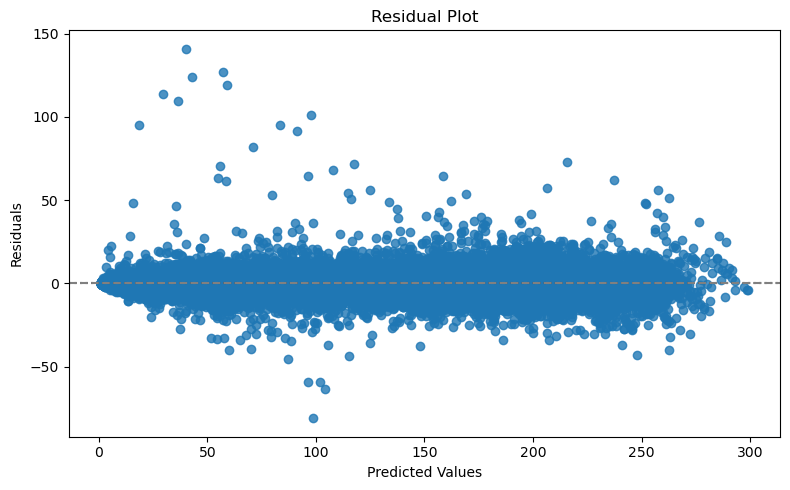

       id    Calories
0  750000   27.249672
1  750001  108.216248
2  750002   87.096779
3  750003  125.582733
4  750004   76.084633

count    250000.000000
mean         88.170555
std          62.251297
min           1.026899
25%          34.034648
50%          76.382866
75%         135.395931
max         296.643555
Name: Calories, dtype: float64


In [ ]:
# kaggle score 0.05850 private, 0.05713 public (autogluon_prediction_6.csv) (tied for 17th place out of 4318 teams)

# Train the model
predictor = TabularPredictor(label='Calories', problem_type='regression', eval_metric='root_mean_squared_error').fit(train_data, presets="best_quality", time_limit=10800, num_bag_folds=5)

# Make predictions
train_pred = predictor.predict(train_data)
test_pred = predictor.predict(test_data)
predictions = predictor.predict(test)

# Evaluate
print()
print("Train prediction:", rmse(train_pred, train_data['Calories']))
print("Test prediction:", rmse(test_pred, test_data['Calories']))



# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(test_pred), y=np.expm1(test_data['Calories']))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(predictions)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("autogluon_prediction_6.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

In [11]:
predictor.leaderboard().head(5)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.059171,root_mean_squared_error,1617.720505,6522.109181,0.004344,4.413985,3,True,33
1,WeightedEnsemble_L2,-0.059310,root_mean_squared_error,1398.207374,1306.083838,0.009399,2.750601,2,True,20
2,ExtraTreesMSE_BAG_L2,-0.059474,root_mean_squared_error,1475.429336,5084.658854,17.059244,148.213780,2,True,24
3,LightGBM_r131_BAG_L2,-0.059570,root_mean_squared_error,1473.459861,4984.474040,15.089769,48.028966,2,True,30
4,LightGBM_BAG_L2,-0.059600,root_mean_squared_error,1460.503701,4951.203948,2.133610,14.758874,2,True,22


In [13]:
info = predictor.info()

In [20]:
info['model_info']['WeightedEnsemble_L3']

{'name': 'WeightedEnsemble_L3',
 'model_type': 'WeightedEnsembleModel',
 'problem_type': 'regression',
 'eval_metric': 'root_mean_squared_error',
 'stopping_metric': 'root_mean_squared_error',
 'fit_time': 4.41398549079895,
 'num_classes': None,
 'quantile_levels': None,
 'predict_time': 0.00434422492980957,
 'val_score': np.float64(-0.05917111920106526),
 'hyperparameters': {'use_orig_features': False,
  'valid_stacker': True,
  'max_base_models': 0,
  'max_base_models_per_type': 'auto',
  'save_bag_folds': True,
  'stratify': 'auto',
  'bin': 'auto',
  'n_bins': None},
 'hyperparameters_user': {'save_bag_folds': True},
 'hyperparameters_fit': {},
 'hyperparameters_nondefault': ['save_bag_folds'],
 'ag_args_fit': {'max_memory_usage_ratio': 1.0,
  'max_time_limit_ratio': 1.0,
  'max_time_limit': None,
  'min_time_limit': 0,
  'valid_raw_types': None,
  'valid_special_types': None,
  'ignored_type_group_special': None,
  'ignored_type_group_raw': None,
  'get_features_kwargs': None,
  '

In [18]:
info['model_info']['WeightedEnsemble_L3']['features']

['XGBoost_BAG_L1',
 'LightGBM_r96_BAG_L1',
 'LightGBM_BAG_L1',
 'LightGBMLarge_BAG_L2',
 'ExtraTreesMSE_BAG_L2',
 'LightGBMXT_BAG_L2',
 'XGBoost_r33_BAG_L1',
 'RandomForestMSE_BAG_L2',
 'NeuralNetFastAI_BAG_L2',
 'LightGBMXT_BAG_L1',
 'NeuralNetFastAI_BAG_L1',
 'ExtraTrees_r42_BAG_L1',
 'LightGBMLarge_BAG_L1',
 'LightGBM_BAG_L2']

In [ ]:
# load predictor - 17th place out of 4318

predictor = TabularPredictor.load(r'c:\Users\eblac\Documents\GitHub\S25_Predict_Calories\AutogluonModels\ag-20250608_151409')

In [16]:
# make the submission file!

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(predictions)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("autogluon_prediction_5.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   27.231379
1  750001  106.367813
2  750002   86.541473
3  750003  125.257576
4  750004   75.616745

count    250000.000000
mean         87.954445
std          62.076649
min           1.031719
25%          34.010962
50%          76.058853
75%         134.917290
max         297.208252
Name: Calories, dtype: float64
